In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
import importlib

import sys
sys.path.append('../dj_modules/')
import dj_metadata as djm
import dj_populate as djp
importlib.reload(djm)
importlib.reload(djp)

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp

dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
dj.conn()

[2024-10-31 09:03:06,692][INFO]: Connecting root@127.0.0.1:3306
[2024-10-31 09:03:06,937][INFO]: Connected root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

In [2]:
str_metadata_dir = '/Volumes/data-1/data/metadata/json/'
# djm.load_metadata(str_metadata_dir)
# djp.load_chunks_and_files()
# djp.load_typing()

In [22]:
# ls_protocols = djm.search_protocol('presentimage')
# print(ls_protocols)

ls_protocols = ['manookinlab.protocols.PresentImages']
df_meta = djm.meta_from_protocol(ls_protocols)

In [23]:
# Keep only following group labels
ls_keep = ['phase noise images',  'phase noise',
       'Vyom texture phase noise',
      'texture phase noise', 
       'wavestrap imgs',
       'wavelet wavestrap imgs', 'wavestrap']
df_meta = df_meta[df_meta['group_label'].isin(ls_keep)]

In [26]:
df_ct = djm.celltyping_from_meta(df_meta).reset_index()
df_ct.head()

,date_id,protocol_id,group_idx,noise_data_file,block_idx,chunk_id,noise_data_files,algorithm,b_typing_file_exists,typing_file,num_cells,num_goodcells,num_on_p,num_off_p,num_on_m,num_off_m,num_sbc
0,20230613C,manookinlab.protocols.FastNoise,2,data036,0,chunk4,data036,kilosort2,1,/Volumes/data-1/analysis/20230613C/chunk4/kilo...,709,709,45,72,59,166,1
1,20230614C,manookinlab.protocols.FastNoise,3,data038,0,chunk4,data038,kilosort2,1,/Volumes/data-1/analysis/20230614C/chunk4/kilo...,842,842,44,95,94,119,0
2,20230725C,manookinlab.protocols.FastNoise,3,data038,0,chunk4,data038,kilosort2,1,/Volumes/data-1/analysis/20230725C/chunk4/kilo...,418,418,39,35,67,100,0
3,20240717C,manookinlab.protocols.SpatialNoise,1,data006,0,chunk2,data006,kilosort2.5,1,/Volumes/data-1/analysis/20240717C/chunk2/kilo...,529,529,37,34,90,77,0
4,20240717C,manookinlab.protocols.SpatialNoise,1,data006,0,chunk2,data006,kilosort2.5,1,/Volumes/data-1/analysis/20240717C/chunk2/kilo...,2,2,37,34,90,77,0


In [27]:
# Keep only kilosort2, and add column for date_chunk
df_ct = df_ct[df_ct['algorithm'] == 'kilosort2']
df_ct['date_chunk'] = df_ct['date_id'] + '_' + df_ct['chunk_id']

df_meta = df_meta.reset_index()
df_meta['date_chunk'] = df_meta['date_id'] + '_' + df_meta['chunk_id']
df_meta.head()

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label,date_chunk
0,20230607C,manookinlab.protocols.PresentImages,1,data019,0,chunk2,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",792,phase noise images,20230607Cm1,20230607C_chunk2
1,20230613C,manookinlab.protocols.PresentImages,1,data033,0,chunk4,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",512,phase noise images,20230613Cm1,20230613C_chunk4
2,20230613C,manookinlab.protocols.PresentImages,3,data028,1,chunk4,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",301,phase noise images,20230613Cm1,20230613C_chunk4
3,20230613C,manookinlab.protocols.PresentImages,3,data029,0,chunk4,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",120,phase noise images,20230613Cm1,20230613C_chunk4
4,20230614C,manookinlab.protocols.PresentImages,1,data029,0,chunk4,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",1584,phase noise,20230614Cm1,20230614C_chunk4


In [28]:
# For unique date_chunks, keep only one with greatest num_goodcells
for date_chunk in df_ct['date_chunk'].unique():
    df_temp = df_ct[df_ct['date_chunk'] == date_chunk]
    if len(df_temp) == 1:
        continue
    int_max = df_temp['num_goodcells'].max()
    df_ct = df_ct.drop(df_temp[df_temp['num_goodcells'] < int_max].index)

20230613C_chunk4
Loading STA from /Volumes/data-1/analysis/20230613C/chunk4/kilosort2/kilosort2.params...
Loaded STA for 960 cells.
20230614C_chunk4
Loading STA from /Volumes/data-1/analysis/20230614C/chunk4/kilosort2/kilosort2.params...
Loaded STA for 842 cells.
20230725C_chunk4
Loading STA from /Volumes/data-1/analysis/20230725C/chunk4/kilosort2/kilosort2.params...
Loaded STA for 588 cells.


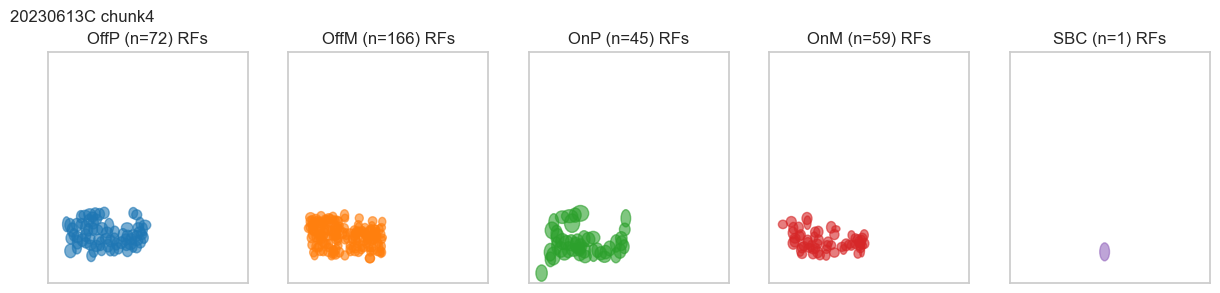

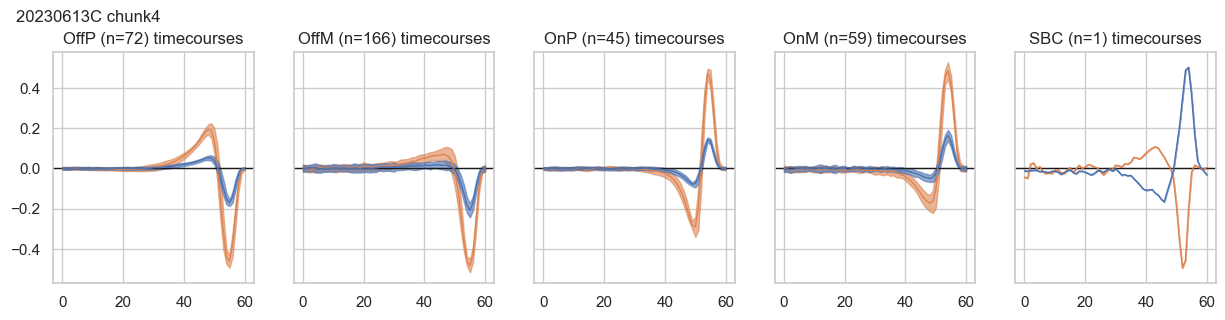

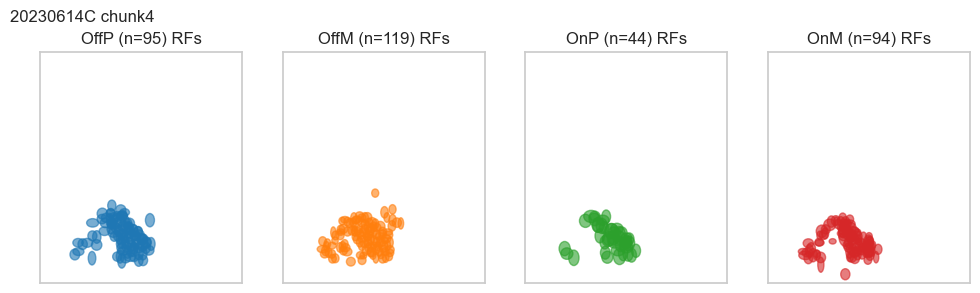

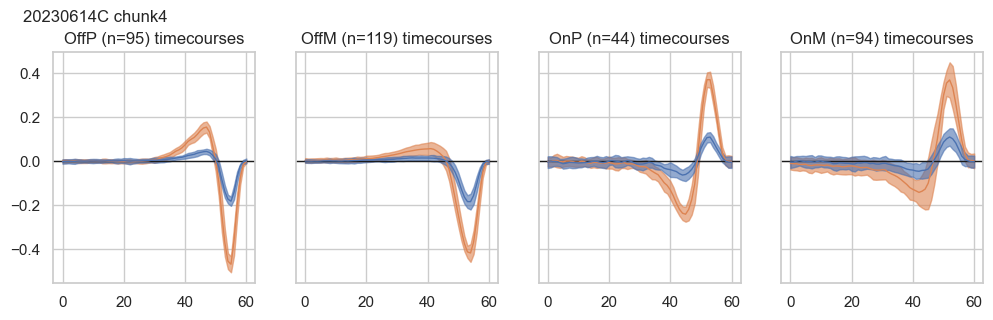

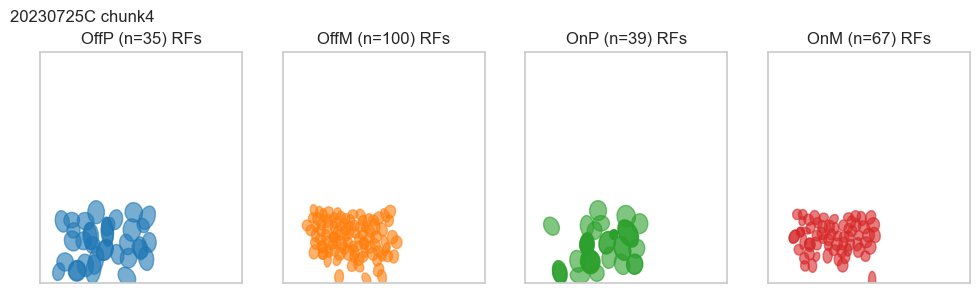

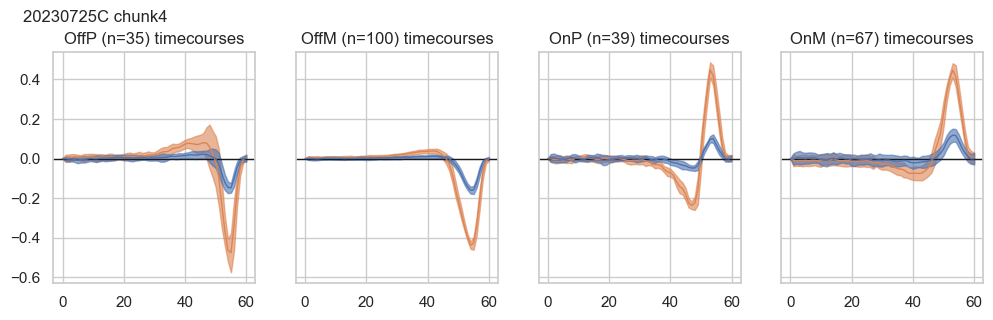

In [29]:
# For every date-chunk pair in df_meta with existing celltyping file in df_ct, 
# create data obj and plot RF mosaics

for str_dataset in df_ct['date_chunk'].unique():
    # str_dataset = df_ct['date_chunk'].unique()[0]
    try:
        date_id = str_dataset.split('_')[0]
        chunk_id = str_dataset.split('_')[1]
        print(str_dataset)
        typing_file = df_ct[df_ct['date_chunk'] == str_dataset]['typing_file'].values[0]

        file_names = df_meta[(df_meta['date_id']==date_id) & (df_meta['chunk_id']==chunk_id)]['data_file'].values
                            
        d_paths =  {
        "str_experiment": date_id,

        "ls_filenames": list(file_names),
        "dataset_name": 'kilosort2',
        "str_algo": 'kilosort2',
        "str_chunk": chunk_id,
        "str_classification": typing_file,
        "str_protocol": "noise",
        'paramsfile': os.path.join(djp.STR_ANALYSIS_PATH, date_id, chunk_id, 'kilosort2', 'kilosort2.params'),
        }

        data = so.SpikeOutputs(**d_paths)
        if len(data.types.d_main_IDs) == 0:
            continue
        data.load_sta_from_params()
        _ = sp.plot_type_rfs_and_tcs(data)
    except Exception as e:
        print(e)
        continue

In [31]:
df_ct[df_ct['date_chunk']=='20230613C_chunk4']['typing_file'].values

array(['/Volumes/data-1/analysis/20230613C/chunk4/kilosort2/20230613C_vr_kilosort2_chunk4_20230627.classification.txt'],
      dtype=object)

In [32]:
df_20230111C = djm.meta_from_date(['20230613C']).reset_index().sort_values('data_file')
df_20230111C

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label
10,20230613C,manookinlab.protocols.FastNoise,0,data000,0,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",24,noise,20230613Cm1
7,20230613C,manookinlab.protocols.ContrastResponseGrating,1,data001,0,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",6,CRF,20230613Cm1
3,20230613C,manookinlab.protocols.AdaptNoiseColorSteps,2,data002,1,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",1,chromatic noise,20230613Cm1
4,20230613C,manookinlab.protocols.AdaptNoiseColorSteps,2,data003,0,chunk1,"[[0.0, 16.0, 33.0, 50.0, 66.0, 83.0, 99.0, 116...",3,chromatic noise,20230613Cm1
1,20230613C,manookinlab.protocols.AdaptNoiseColorSteps,0,data004,0,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",5,achromatic noise,20230613Cm1
17,20230613C,manookinlab.protocols.MovingBarColorAdapt,0,data005,0,chunk1,"[[0.0, 16.0, 33.0, 50.0, 66.0, 83.0, 99.0, 116...",150,moving bar adapt,20230613Cm1
9,20230613C,manookinlab.protocols.DovesMovie,0,data006,0,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",90,DOVEs reps,20230613Cm1
20,20230613C,manookinlab.protocols.NoiseSizeModulation,0,data007,0,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",30,delta size,20230613Cm1
22,20230613C,manookinlab.protocols.NoiseSizeModulation,2,data008,0,chunk1,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",14,delta time,20230613Cm1
19,20230613C,manookinlab.protocols.MovingChromaticBar,1,data009,0,chunk2,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",192,oriented bars,20230613Cm1


In [7]:
# 20230111C
df_meta[df_meta.date_id == '20230111C'].sort_values(by='data_file')

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label,date_chunk
63,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data010,0,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 158...",40,Natural Image Flash 4 nd,,20230111C_chunk1
64,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data011,1,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural Image Flash 4 nd,,20230111C_chunk1
74,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,5,data013,0,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 2 nd,,20230111C_chunk1
75,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,5,data014,1,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 2 nd,,20230111C_chunk1
70,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,3,data016,0,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 0 nd,,20230111C_chunk1
71,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,3,data017,1,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 0 nd,,20230111C_chunk1
72,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,4,data031,0,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 158...",40,Natural image flash 1 nd,,20230111C_chunk3
73,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,4,data032,1,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 1 nd,,20230111C_chunk3
76,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,6,data034,0,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 158...",40,Natural image flash 3 nd,,20230111C_chunk3
77,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,6,data035,1,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 3 nd,,20230111C_chunk3
